# Random Forest regressor

In [2]:
from sklearn.ensemble import RandomForestRegressor
from utils.utils_pixel import *
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/dccstor/cimf/drought_impact/drought/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_timesteps_in = 9
n_timesteps_out = 1
n_feats_in = 85
n_feats_out = 1
exp_train = 'filtered_summer_clean'
exp = 'filtered_clean'
sample_type = 'pixel_data'
feature_set = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "CP", "NDVI", "SCL",
               "VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SR" ,"SP", "T", "TCC", "TP", 
               "DEM", 
               "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21",
               "CLAY0_5", "CLAY100_200", "CLAY15_30", "CLAY30_60", "CLAY5_15", "CLAY60_100",
               "FED0_5", "FED100_200", "FED15_30",  "FED30_60", "FED5_15", "FED60_100",
               "FC", "FH",
               "GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15", "SAND60_100",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]
remove_band = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "CP", "SCL",
               "VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SP", "TCC",
               "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21",
               "CLAY0_5", "CLAY100_200", "CLAY15_30", "CLAY30_60", "CLAY5_15", "CLAY60_100",
               "FED0_5", "FED100_200", "FED15_30",  "FED30_60", "FED5_15", "FED60_100",
               "FC", "FH",
               "GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15", "SAND60_100",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]


n_epochs = 100
n_batches = 276
n_batches_val = 58
n_batches_te = 42
batch_size = 40

In [4]:
def get_val_metrics(rf, batch_size, n_batches_val, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band):

    r2_tot = 0
    mse_tot = 0
    
    for batch_nbr in range(n_batches_val):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='val', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 0 #NDVI only
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))
        

        # calculate the MSE loss
        y_pred = rf.predict(X_batch)
        mse_tot += mean_squared_error(y_batch, y_pred)
        # Calculate R2 per sample
        r2_batch = 0 
        for sample in range(batch_size):
            y_true = np.concatenate([img[sample,:,0,:,:], label[sample,:,:,:]]).squeeze(1).squeeze(1)
            y_pred_all = np.concatenate([img[sample,:,0,:,:].squeeze(1).squeeze(1), [y_pred[sample]]])
            r2_batch += r2_score(y_true, y_pred_all)
        r2_tot += r2_batch/batch_size
    
    return r2_tot/n_batches_val, mse_tot/n_batches_val


def get_test_metrics(rf, batch_size, n_batches_te, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band):
    
    r2_tot = 0
    mse_tot = 0
    
    for batch_nbr in range(n_batches_te):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='test', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 0 #NDVI only
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

        # calculate the MSE loss
        y_pred = rf.predict(X_batch)
        mse_tot += mean_squared_error(y_batch, y_pred)
        r2_batch = 0 
        # Calculate R2 per sample
        for sample in range(batch_size):
            y_true = np.concatenate([img[sample,:,0,:,:], label[sample,:,:,:]]).squeeze(1).squeeze(1)
            y_pred_all = np.concatenate([img[sample,:,0,:,:].squeeze(1).squeeze(1), [y_pred[sample]]])
            r2_batch += r2_score(y_true, y_pred_all)
        r2_tot += r2_batch/batch_size
    
    return r2_tot/n_batches_te, mse_tot/n_batches_te

In [83]:
rf = RandomForestRegressor(random_state=42)

for epoch in tqdm(range(1)):
    for batch_nbr in range(n_batches):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here 
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='train', exp=exp_train, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)
        
        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 0
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

        # fit the regressor on the current batch
        rf.fit(X_batch, y_batch.ravel())
    
    r2, mse = get_val_metrics(rf, batch_size, n_batches_val, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
    print(f'Validation metrics for epoch {epoch}: R2 {r2}. MSE {mse}.') 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:19<00:00, 79.21s/it]

Validation metrics for epoch 0: R2 0.2997928943477223. MSE 0.06644230146337748.


In [5]:
"""
# Save model for future use
with open('RF_clean_filt_summer.pkl', 'wb') as f:
    pickle.dump(rf, f)
"""
with open('RF_clean_filt_summer.pkl', 'rb') as f:
    rf = pickle.load(f)


In [6]:
# Evaluate on val set

r2_val, mse_val = get_val_metrics(rf, batch_size, n_batches_val, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
print(f"Val MSE: {mse_val}, Val R2: {r2_val}")

Val MSE: 0.06644230146337748, Val R2: 0.2997928943477223


In [86]:
# Evaluate on test set

r2_test, mse_test = get_test_metrics(rf, batch_size, n_batches_te, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
print(f"Test MSE: {mse_test}, test R2: {r2_test}")

Test MSE: 0.05611198312780602, test R2: 0.5978155596148694


# Plot predictions

In [87]:
exp = 'nofilter'
batch = 40
batch_size = 40 
split = 'test'

metadata_path = f'pixel_data/nofilter/{split}/'

# Get date/range of pred
all_loc_dates_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('all_loc_dates')])

all_loc_dates = []
for f in all_loc_dates_files:
    with open(metadata_path+f, 'rb') as f :
        all_loc_dates += pickle.load(f)
        
n_rep = 4000/len(all_loc_dates)
idx_start = int(np.floor((batch_size*batch)/n_rep))
idx_last = int(np.floor((batch_size*batch + batch_size)/n_rep))

metadata_path = f'pixel_data/nofilter/{split}/'
split_path = f'/dccstor/cimf/drought_impact/pixel_based/pixel_data/filtered/{split}/'
with open(split_path+'cloud_free_samples.pkl', 'rb') as f:
    cloud_free_samples = pickle.load(f)

In [88]:
# Plot some preds on the test set

img, label = load_batch(batch_size = batch_size, batch_nbr =batch, sample_type = 'pixel_data', split=split, exp='filtered_clean', n_timesteps_out=1)

img = remove_features_batch_level(img, remove_band, feature_set)
label = remove_features_batch_level(label, remove_band, feature_set)

# still predict both, but dont use cp_idx for masking clouds in loss
#cp_mask = label[:,:,0,:,:].squeeze(1).squeeze(1).squeeze(1).detach()
to_keep = 0 #NDVI only
label = label[:,:,to_keep,:,:]

X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

# Concatenate all timesteps after each other
X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

# calculate the MSE loss
y_pred = rf.predict(X_batch)

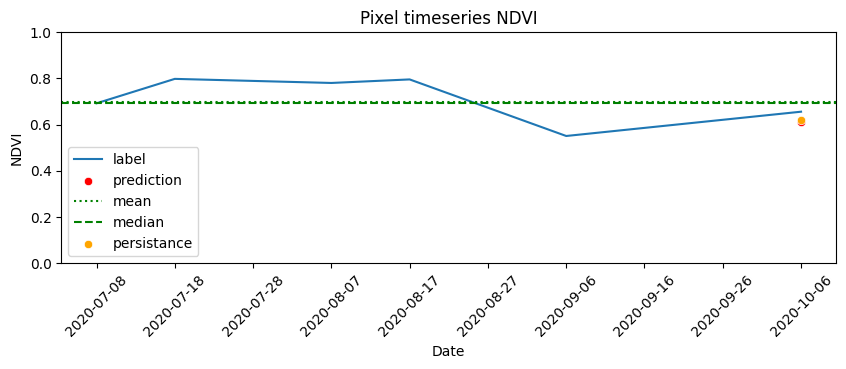

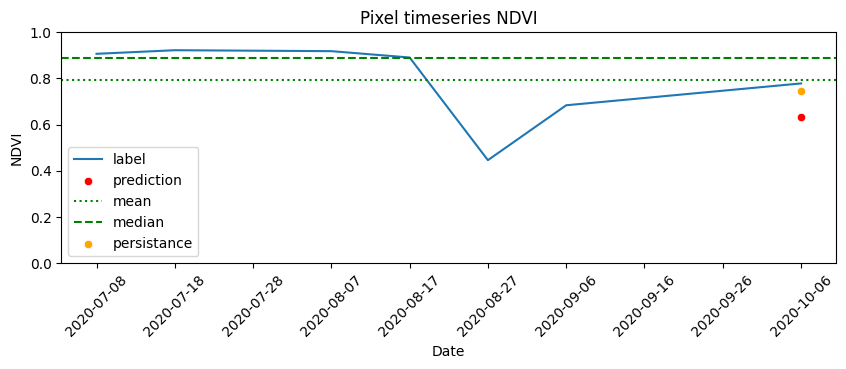

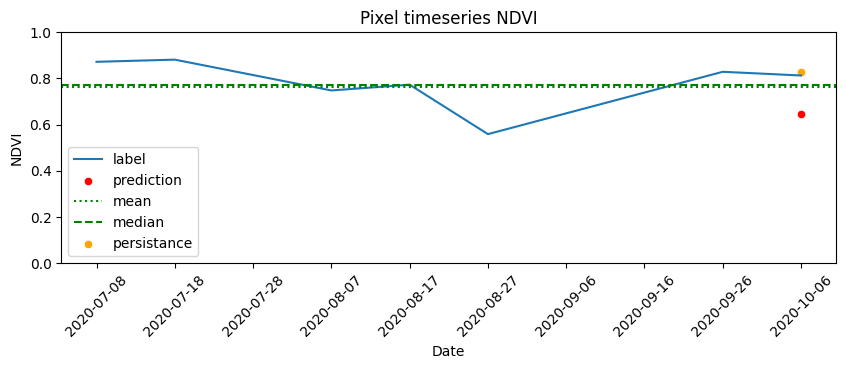

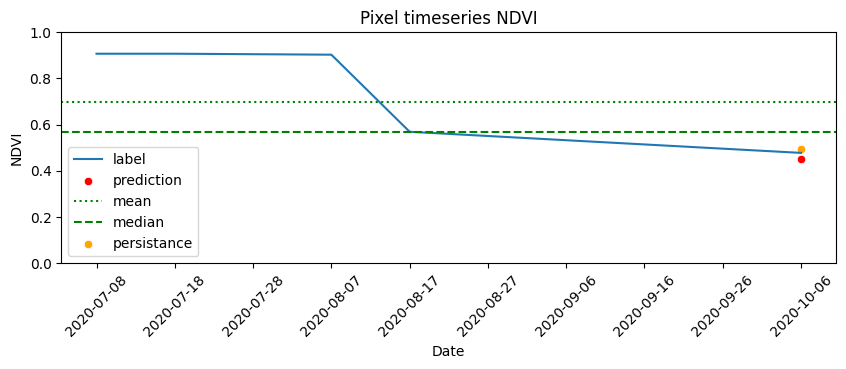

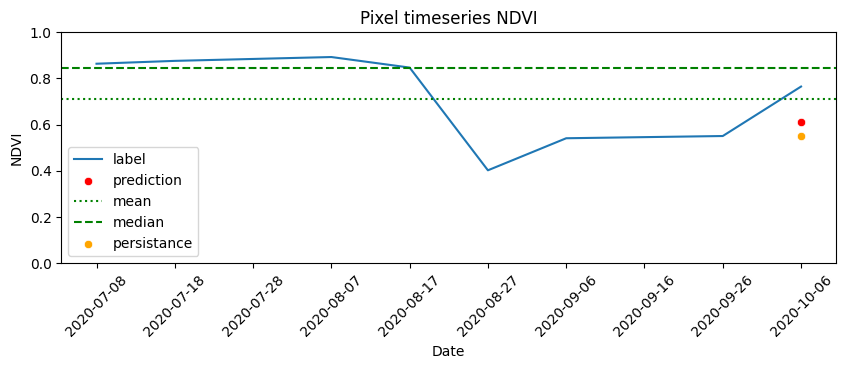

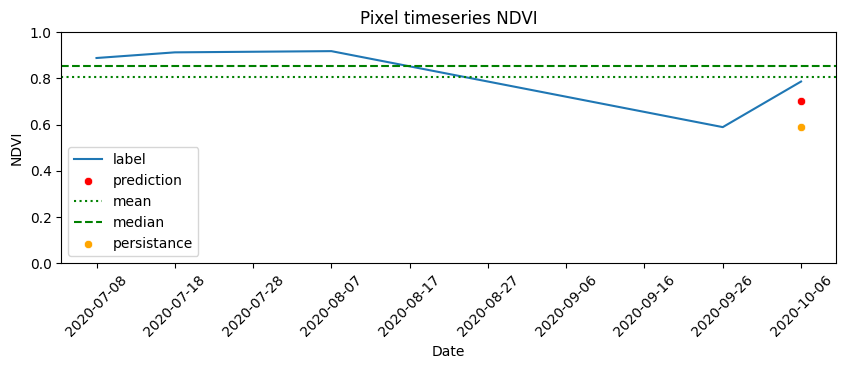

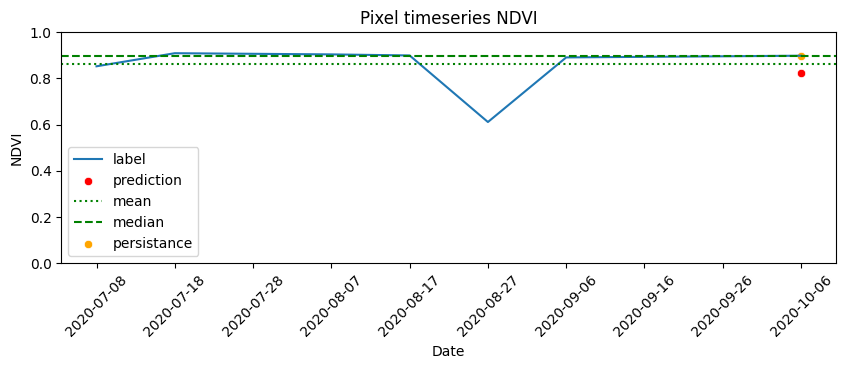

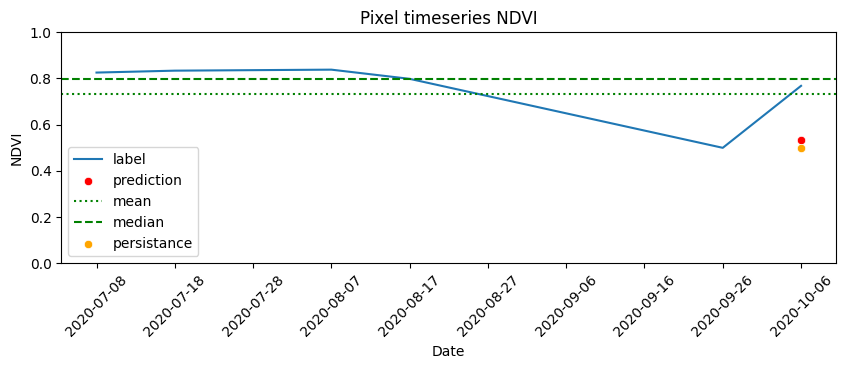

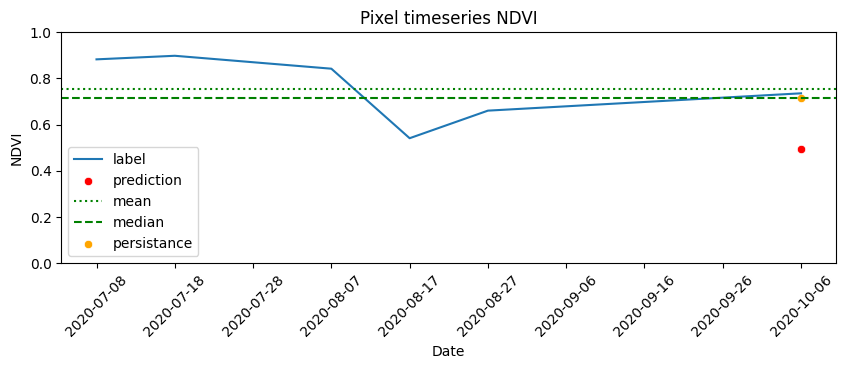

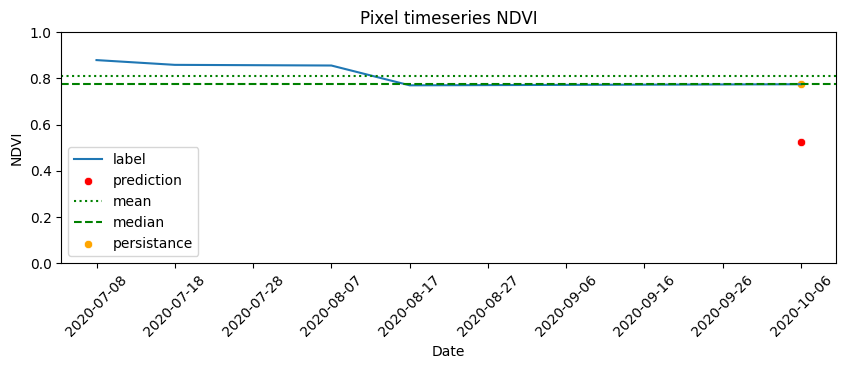

In [89]:
for sample_id in range(10):
    ndvi_input = img[sample_id, :, 0, :, :].squeeze(1).squeeze(1)
    ndvi_label = label[sample_id, :, :, :].squeeze(1).squeeze(1)
    ndvi_cleaned = th.cat([ndvi_input, ndvi_label])
    
    filtered_idx = int(np.floor(cloud_free_samples[batch*batch_size+sample_id]/n_rep))
    dates = all_loc_dates[filtered_idx][1] + all_loc_dates[filtered_idx][3][:1]

    pix_pred = y_pred[sample_id]
    tensor_of_nans = th.full(ndvi_input.shape, float('nan')).numpy()
    #print(tensor_of_nans.shape, [pix_pred].shape)
    pix_pred = np.concatenate([tensor_of_nans, [pix_pred]])

    fig, ax = plt.subplots(1,1,figsize=(10,3))
    plt.title('Pixel timeseries NDVI')
    sns.lineplot(ax=ax, y=ndvi_cleaned, x=dates,label='label')
    # add dot of predicted NDVI 
    sns.scatterplot(ax=ax, y=pix_pred, x=dates,label='prediction', color='red')
    # add mean and median
    plt.axhline(y = ndvi_input.mean(), color = 'green', linestyle = ':', label='mean')
    plt.axhline(y = ndvi_input.median(), color = 'green', linestyle = '--', label='median')
    # add dot of persistance prediction  
    pix_pers = ndvi_input[-1].detach().unsqueeze(0)
    tensor_of_nans = th.full(ndvi_input.shape, float('nan'))
    pix_pers = th.cat([tensor_of_nans, pix_pers])
    sns.scatterplot(ax=ax, y=pix_pers, x=dates,label='persistance', color='orange')
    
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.ylim(0,1)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Residual analysis

In [7]:
def get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band):
    
    y_pred_all = list()
    label_all = list()
    
    for batch_nbr in range(n_batches):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split=split, exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 0 #NDVI only
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))
        

        # calculate the MSE loss
        y_pred = rf.predict(X_batch)
        
        y_pred_all.append(y_pred)
        label_all.append(label)
        
        
    return y_pred_all, label_all

In [8]:
split = 'val'
batch_size = 40
n_batches = 58

y_pred_val, label_val = get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
y_pred_val = np.concatenate(y_pred_val)
label_val = np.concatenate(label_val).squeeze(1).squeeze(1).squeeze(1)

In [9]:
split = 'test'
batch_size = 40
n_batches = 42

y_pred_test, label_test = get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
y_pred_test = np.concatenate(y_pred_test)
label_test = np.concatenate(label_test).squeeze(1).squeeze(1).squeeze(1)

In [10]:
split = 'train'
batch_size = 40
n_batches = 276
exp = 'filtered_summer_clean'

y_pred_train, label_train = get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
y_pred_train = np.concatenate(y_pred_train)
label_train = np.concatenate(label_train).squeeze(1).squeeze(1).squeeze(1)

In [11]:
# Residual vs label ndvi

df = pd.DataFrame(data=label_test, columns=['label'], index=np.arange(0,len(label_test),1))
df['pred'] = y_pred_test
df['set'] = ['test']*len(label_test)

df_val = pd.DataFrame(data=label_val, columns=['label'], index=np.arange(0,len(label_val),1))
df_val['pred'] = y_pred_val
df_val['set'] = ['val']*len(label_val)

df_tr = pd.DataFrame(data=label_train, columns=['label'], index=np.arange(0,len(label_train),1))
df_tr['pred'] = y_pred_train
df_tr['set'] = ['train']*len(label_train)

df_all = pd.concat([df_tr, df_val, df], axis=0, ignore_index=True)
df_all['res'] = df_all['label'] - df_all['pred']

In [12]:
df_all

,label,pred,set,res
0,0.933420,0.787642,train,0.145778
1,0.932041,0.910919,train,0.021122
2,0.926448,0.877171,train,0.049278
3,0.870135,0.916446,train,-0.046311
4,0.915262,0.866728,train,0.048534
...,...,...,...,...
15035,0.744484,0.629201,test,0.115283
15036,0.543978,0.589942,test,-0.045964
15037,0.692384,0.753121,test,-0.060736
15038,0.705103,0.629878,test,0.075224


Text(0, 0.5, 'Residual')

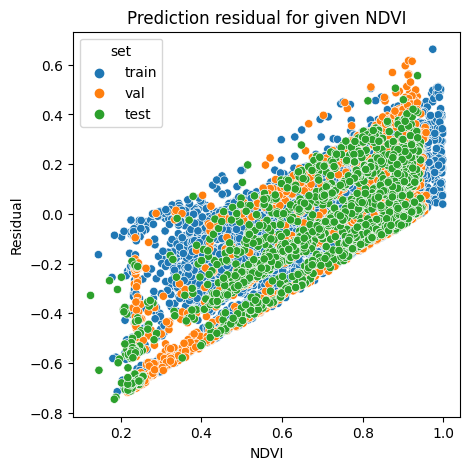

In [13]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
plt.title('Prediction residual for given NDVI')
sns.scatterplot(ax=ax, y='res', x='label', data=df_all, hue='set')
plt.xlabel('NDVI')
plt.ylabel('Residual')

Text(0, 0.5, 'Residual')

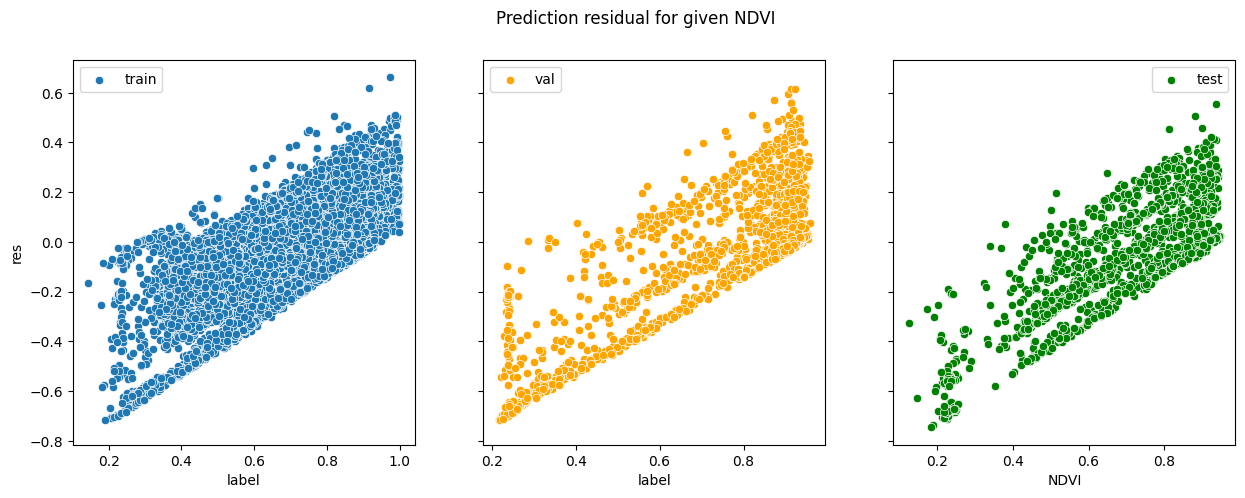

In [14]:
fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=True)
plt.suptitle('Prediction residual for given NDVI')
sns.scatterplot(ax=axs[0], y='res', x='label', data=df_all[df_all.set=='train'], label='train')
sns.scatterplot(ax=axs[1], y='res', x='label', data=df_all[df_all.set=='val'], label='val', color='orange')
sns.scatterplot(ax=axs[2], y='res', x='label', data=df_all[df_all.set=='test'], label='test', color='green')
plt.xlabel('NDVI')
plt.ylabel('Residual')

Text(0, 0.5, 'Pred')

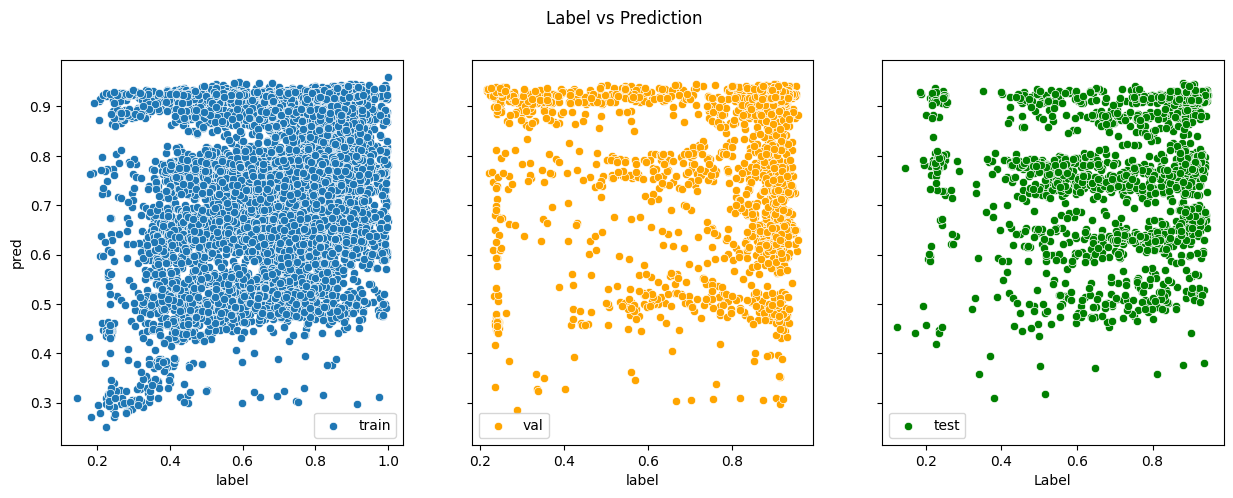

In [15]:
# Plot: pred vs label

fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=True)
plt.suptitle('Label vs Prediction')
sns.scatterplot(ax=axs[0],  y='pred', x='label', data=df_all[df_all.set=='train'], label='train')
sns.scatterplot(ax=axs[1], y='pred', x='label', data=df_all[df_all.set=='val'], label='val', color='orange')
sns.scatterplot(ax=axs[2],  y='pred', x='label', data=df_all[df_all.set=='test'], label='test', color='green')
plt.xlabel('Label')
plt.ylabel('Pred')